In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
torch.__version__

'1.3.0'

In [2]:
class GradientInput(nn.Module):
    """DNN version"""
    def __init__(self, input_size, hidden_sizes, output_size):
        super(GradientInput, self).__init__()
        layers = []
        hs_f = input_size
        if isinstance(hidden_sizes, list):
            for hs_b in hidden_sizes:
                layers.append(nn.Linear(hs_f, hs_b))
                layers.append(nn.ReLU())
                hs_f = hs_b
        else:
            hs_b = hidden_sizes
            layers.append(nn.Linear(hs_f, hs_b))
        layers.append(nn.Linear(hs_b, output_size))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        output = self.layers(x)
        return output

In [40]:
class GradientInput(nn.Module):
    """CNN version"""
    def __init__(self, output_size):
        super(GradientInput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=1),  # (B, 1, 32, 32) -> (B, 32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 28, 28) -> (B, 32, 14, 14)
            nn.Conv2d(32, 64, 5, padding=1),  # (B, 32, 14, 14) -> (B, 64, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(2)  # (B, 64, 12, 12) -> (B, 64, 6, 6)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 1000),
            nn.Linear(1000, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output

In [92]:
def train(model, train_loader, optimizer, loss_function, device, **kwargs):
    step = kwargs["step"]+1
    n_step = kwargs["n_step"]
    logterm = 30 if kwargs.get("logterm") is None else kwargs["logterm"] 
    model.train()
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        
        # record
        if i % logterm == 0:    
            print(f"[{step}/{n_step}] Progress: {100*i/len(train_loader):.2f}% Batch Average loss: {loss:.4f}")
        
def test(model, test_loader, loss_function, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100*(correct / len(test_loader.dataset))
    
    print(f"\n[Test] Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    return test_loss, accuracy

In [93]:
n_step = 10
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
# ds = datasets.MNIST
ds = datasets.CIFAR10
train_dataset = ds(
    root="../data",                                
    train=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    download=False)
test_dataset = ds(
    root="../data", 
    train=False,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    download=False)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True)

In [94]:
output_size = 10
model = models.vgg16_bn(pretrained=True).to(device)
# model = GradientInput(output_size)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [56]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, output_size)
model = model.to(device)

In [95]:
best_acc = 0.0
for step in range(n_step):
    train(model, train_loader, optimizer, loss_function, device, logterm=400, step=step, n_step=n_step)
    _, test_acc = test(model, test_loader, loss_function, device)
    if test_acc >= best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), "./trained/cifar10-vgg16_bn.pt")
        print("[alert] best model saved")
    print("---"*10)

[1/10] Progress: 0.00% Batch Average loss: 18.0942
[1/10] Progress: 51.15% Batch Average loss: 1.0444

[Test] Average loss: 0.8616, Accuracy: 7308/10000 (73.08%)
[alert] best model saved
------------------------------
[2/10] Progress: 0.00% Batch Average loss: 0.7755
[2/10] Progress: 51.15% Batch Average loss: 0.6724

[Test] Average loss: 0.6197, Accuracy: 8097/10000 (80.97%)
[alert] best model saved
------------------------------
[3/10] Progress: 0.00% Batch Average loss: 0.8084
[3/10] Progress: 51.15% Batch Average loss: 0.6524

[Test] Average loss: 0.5601, Accuracy: 8289/10000 (82.89%)
[alert] best model saved
------------------------------
[4/10] Progress: 0.00% Batch Average loss: 0.6095
[4/10] Progress: 51.15% Batch Average loss: 0.6131

[Test] Average loss: 0.5906, Accuracy: 8209/10000 (82.09%)
------------------------------
[5/10] Progress: 0.00% Batch Average loss: 0.2924
[5/10] Progress: 51.15% Batch Average loss: 0.5104

[Test] Average loss: 0.5191, Accuracy: 8412/10000 (84.

In [ ]:
imgs.

In [61]:
model = model.cpu()
for imgs, labels in test_loader:
    break
    
num = 6
samples = imgs[:num].requires_grad_()
sample_labels = labels[:num]
model.zero_grad()
output = model(samples)
loss = loss_function(output, sample_labels)
loss.backward()
# input * grad
# inputgrads = samples * samples.grad
inputgrads = samples.grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

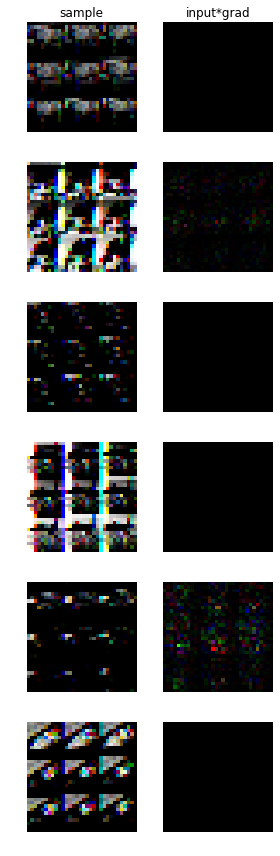

In [69]:
fig, axes = plt.subplots(num, 2, figsize=(4, 12))
for i, (dual_ax, (sample, inputgrad), sample_label) in enumerate(zip(axes, list(zip(*[samples, inputgrads])), sample_labels)):
    # draw
    for ax, name in zip(dual_ax, ["sample", "input*grad"]):
        if name == "sample":
            img = sample
        else:
            img = inputgrad
        ax.imshow(img.permute(32, 32, -1).squeeze().detach())
        ax.grid(False)
        ax.axis("off")
        if i == 0:
            ax.set_title(f"{name}")
plt.tight_layout()
plt.show()